# Imports

In [1]:
from pyiron_contrib.tinybase.project import ProjectAdapter, InMemoryProject

/home/poul/pyiron/contrib/pyiron_contrib/__init__.py:9: UserWarning: pyiron module not found, importing Project from pyiron_base
  warnings.warn("pyiron module not found, importing Project from pyiron_base")


In [2]:
from ase.calculators.morse import MorsePotential

In [3]:
import logging
logging.getLogger().setLevel(20)

# Create Project and a new Job


In [4]:
pr = ProjectAdapter.open_location('tinyjob')

## MD Job

In [5]:
j = pr.create.job.AseMD('md')

In [6]:
j.input.structure = pr.create.structure.bulk('Fe', a=1.2, cubic=True).repeat(2)
j.input.calculator = MorsePotential()

In [7]:
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20

In [8]:
j.run()

In [9]:
j.wait()

In [10]:
j.status

'finished'

In [11]:
# Testing env doesn't have nglview
# j.output.animate_structures()

## Min Job

In [23]:
j = pr.create.job.AseMinimize('min')

In [24]:
j.input.structure = pr.create.structure.atoms(
    symbols=['Fe', 'Fe'], 
    positions=[[0,0,0], [0,0, .75]], 
    cell=[10,10,10]
).to_ase() # since our Atoms cannot be pickled, but parallel execution needs that we still convert back here
j.input.structure.rattle(1e-3)
j.input.calculator = MorsePotential()

In [25]:
j.input.lbfgs(damping=.25)
j.input.ionic_force_tolerance = 1e-3
j.input.max_steps = 100
j.input.output_steps = 10

In [26]:
j.run(
    executor=pr.create.executor.process(4)
)
j.wait()

       Step     Time          Energy         fmax
LBFGS:    0 12:27:58       11.288146      189.5231
LBFGS:    1 12:27:58        1.168671       43.6957
LBFGS:    2 12:27:58        0.860403       38.6924
LBFGS:    3 12:27:58        0.362400       30.3554
LBFGS:    4 12:27:58        0.004806       24.0865
LBFGS:    5 12:27:58       -0.267437       19.0615
LBFGS:    6 12:27:58       -0.471646       15.0628
LBFGS:    7 12:27:58       -0.623506       11.8810
LBFGS:    8 12:27:58       -0.735237        9.3518
LBFGS:    9 12:27:58       -0.816458        7.3435
LBFGS:   10 12:27:58       -0.874705        5.7512
LBFGS:   11 12:27:58       -0.915849        4.4909
LBFGS:   12 12:27:58       -0.944435        3.4955
LBFGS:   13 12:27:58       -0.963943        2.7113
LBFGS:   14 12:27:58       -0.977006        2.0956
LBFGS:   15 12:27:58       -0.985585        1.6137
LBFGS:   16 12:27:58       -0.991109        1.2382
LBFGS:   17 12:27:58       -0.994598        0.9468
LBFGS:   18 12:27:58       -0.99

In [27]:
j.project.database.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,1,pyiron,md,1,1,1,/home/poul/pyiron/contrib/notebooks/tinybase/t...,finished,AseMDTask
1,2,pyiron,min,2,1,3,/home/poul/pyiron/contrib/notebooks/tinybase/t...,finished,AseMinimizeTask


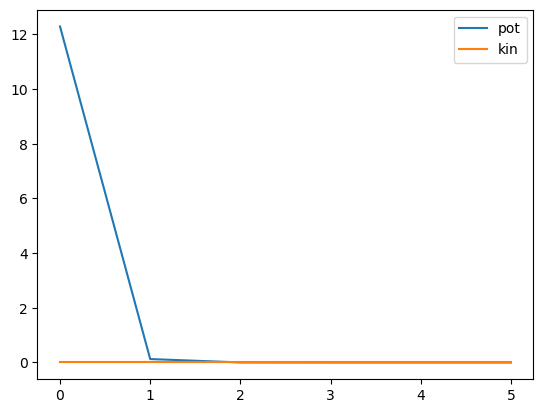

In [28]:
j.output.plot_energies()

In [29]:
# Testing env doesn't have nglview
# j.output.animate_structures()

### Loading from job id or name works

In [30]:
j.output.pot_energies

[11.28814567708869,
 -0.8747049787590951,
 -0.9988764739052705,
 -0.9999959367316252,
 -0.9999999870081488,
 -0.999999995888409]

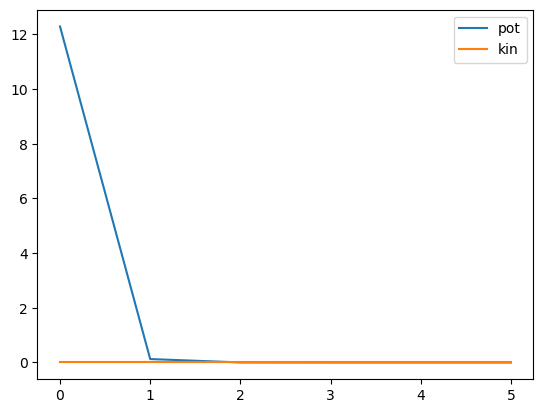

In [31]:
j.project.load(j.id).output.plot_energies()

In [32]:
# Testing env doesn't have nglview
# j.project.load(j.name).output.animate_structures()

## Murnaghan

In [33]:
murn = pr.create.job.Murnaghan('murn')

In [34]:
murn.input.task = pr.create.task.AseStatic()
murn.input.task.input.calculator = MorsePotential()

In [35]:
murn.input.structure = pr.create.structure.bulk("Fe", a=1.2).to_ase() # since our Atoms cannot be pickled, but parallel execution needs that we still convert back here

In [36]:
murn.input.set_strain_range(.5, 1000)

In [37]:
%%time
murn.run(executor='process')
murn.wait()

CPU times: user 1.08 s, sys: 415 ms, total: 1.5 s
Wall time: 11.9 s


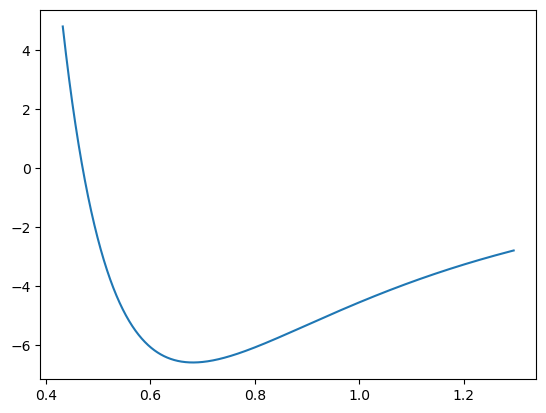

In [38]:
murn.output.plot()

# Pyiron purely in memory

Because the new ProjectInterface completely controls both the storage class and the database a job sees, we can easily swap them without changing anything in `TinyJob` at all.  As a demonstration we can make here a project that persists only for the duration of the process life time.  But it's not hard to imagine a number  of different project type depending on database configuration or storage location (S3, a single HDF5 for all jobs, etc.)

In [39]:
pr = InMemoryProject('/')

In [40]:
pr.job_table()

""


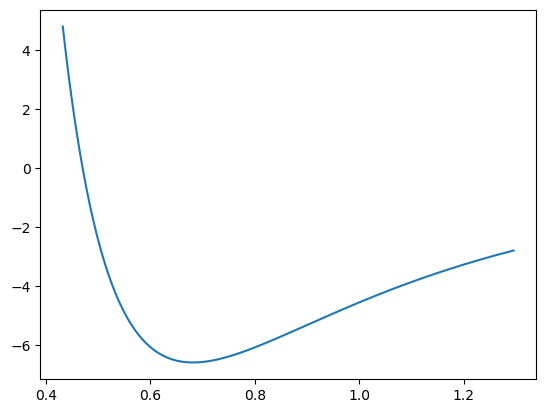

In [41]:
murn = pr.create.job.Murnaghan("murn")
murn.input.task = pr.create.task.AseStatic()
murn.input.task.input.calculator = MorsePotential()
murn.input.structure = pr.create.structure.bulk("Fe", a=1.2).to_ase() # since our Atoms cannot be pickled, but parallel execution needs that we still convert back here
murn.input.set_strain_range(.5, 500)
murn.run(executor='process')
murn.wait()
murn.output.plot()

In [42]:
pr.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,1,pyiron,murn,1,1,1,/,finished,MurnaghanTask


In [43]:
j = pr.create.job.AseMD('md')
j.input.structure = pr.create.structure.bulk('Fe', a=1.2, cubic=True).repeat(2).to_ase() # since our Atoms cannot be pickled, but parallel execution needs that we still convert back here
j.input.calculator = MorsePotential()
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20
j.run(executor='background')
j.wait()

In [44]:
pr.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,1,pyiron,murn,1,1,1,/,finished,MurnaghanTask
1,2,pyiron,md,2,1,2,/,finished,AseMDTask


Subprojects work.

In [45]:
sub = pr.open_location("/foo")
j = sub.create.job.AseMD('md')
j.input.structure = pr.create.structure.bulk('Fe', a=1.2, cubic=True).repeat(2).to_ase() # since our Atoms cannot be pickled, but parallel execution needs that we still convert back here
j.input.calculator = MorsePotential()
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20
j.run()

In [46]:
pr.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,1,pyiron,murn,1,1,1,/,finished,MurnaghanTask
1,2,pyiron,md,2,1,2,/,finished,AseMDTask
2,3,pyiron,md,2,2,3,/foo,finished,AseMDTask
